# Sentiment Timeseries

In [376]:
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [377]:
df = pd.read_csv(pathlib.Path("../data/news_select_companies_with_sent.csv"))
df

,Unnamed: 0,id,ticker,title,category,content,release_date,provider,url,article_id,dic_sentiment,dic_sentiment_dis
0,1305,222820,MSFT,Microsoft exposed 250M customer support records,news,Microsoft MSFT 0 1 discloses a database er...,2020-01-23,Seeking Alpha,https://invst.ly/pli4a,2065317,-0.0258,-1
1,1307,222822,MSFT,Microsoft CEO Fears U S China Mistrust Will H...,news,Bloomberg Sign up here to receive the Dav...,2020-01-21,Bloomberg,https://www.investing.com/news/stock-market-ne...,2063837,0.9620,1
2,3760,225275,MSFT,China Coronavirus Sells Off Asian Markets,opinion,Tuesday January 21 2020Market futures are in...,2020-01-20,Zacks Investment Research,https://www.investing.com/analysis/china-coron...,200500300,0.6584,1
3,3761,225276,MSFT,Tech Daily Facebook Apple Digital Taxes More,opinion,Facebook s NASDAQ FB role in elections and...,2020-01-21,Zacks Investment Research,https://www.investing.com/analysis/tech-daily-...,200500369,0.9970,1
4,3762,225277,MSFT,Chart Of The Day Can IBM s Results Help Avert...,opinion,International Business Machines NYSE IBM is ...,2020-01-21,Pinchas Cohen/Investing.com,https://www.investing.com/analysis/chart-of-th...,200500192,0.0979,1
...,...,...,...,...,...,...,...,...,...,...,...,...
60390,221241,442757,PFE,PSivida Small Cap BioTech Positioned For Long...,opinion,The following small cap company I find very in...,2012-04-18,Scott Matusow,https://www.investing.com/analysis/psivida:-sm...,120599,0.9997,1
60391,221246,442762,PFE,Cheap Is Not Always Good And Stocks As Sweaters,opinion,Cheap Is Not Always GoodThere are many investo...,2011-11-23,Helix Investment Management,https://www.investing.com/analysis/cheap-is-no...,106549,0.9922,1
60392,221247,442763,PFE,PROLOR Biotech A Top Takeover Candidate,opinion,Billionaire Phillip Frost is an esteemed entre...,2011-12-06,Takeover Analyst,https://www.investing.com/analysis/prolor-biot...,107900,0.9941,1
60393,221248,442764,PFE,2 Defensive Dividend Stocks Outperforming The SP,opinion,Looking to play defense in the market As the ...,2011-12-19,Double Dividend Stocks,https://www.investing.com/analysis/2-defensive...,109101,0.9951,1


# Data Cleaning

There can be more articles per day, so lets group those per ticker. When grouping, take the sum of all the sentiment values on one day. By summing we are taking in account the higher sentiment on the stock when there are more articles on one day.

In [378]:
sentiment_df = df[["ticker", "release_date", "dic_sentiment"]]
sentiment_df = sentiment_df.groupby(["release_date", "ticker"]).sum()
sentiment_df = sentiment_df.reset_index()
sentiment_df

,release_date,ticker,dic_sentiment
0,2008-10-06,CVX,-0.9949
1,2008-10-07,BAC,-1.9426
2,2008-10-15,HD,-1.9971
3,2008-10-15,MSFT,0.0771
4,2008-10-29,WMT,-0.9717
...,...,...,...
17416,2020-02-12,JPM,5.9644
17417,2020-02-12,MRK,0.7162
17418,2020-02-12,NVDA,0.1390
17419,2020-02-13,PFE,0.2732


In [379]:
sentiment_df = sentiment_df.pivot_table(index = sentiment_df["release_date"], columns=['ticker'], values='dic_sentiment')
sentiment_df

ticker,AAPL,AMZN,BAC,CVX,HD,JNJ,JPM,KO,LLY,MA,MRK,MSFT,NVDA,PFE,PG,TSLA,UNH,V,WMT,XOM
release_date,,,,,,,,,,,,,,,,,,,,
2008-10-06,NaN,NaN,NaN,-0.9949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-07,NaN,NaN,-1.9426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-15,NaN,NaN,NaN,NaN,-1.9971,NaN,NaN,NaN,NaN,NaN,NaN,0.0771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.9717,NaN
2008-10-31,NaN,NaN,0.6914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-09,NaN,NaN,NaN,1.9594,NaN,0.9927,1.7212,NaN,NaN,NaN,NaN,NaN,-0.4215,NaN,NaN,NaN,NaN,NaN,0.3612,NaN
2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,4.3950,NaN,NaN,0.9851,2.3016,NaN,3.8331,NaN,NaN,NaN,NaN,NaN,NaN,-0.5306
2020-02-11,NaN,NaN,NaN,0.0732,NaN,2.3224,1.9714,NaN,NaN,NaN,NaN,NaN,NaN,1.5383,NaN,NaN,NaN,NaN,NaN,1.9926


For each column, fill the NaN values with the previous normal value.

One could argue that interpolating between the two surrounding values gives better results. An argument against this method is the fact that on the date of a specific NaN value, the next sentiment value was unknown, because it is in the future.

In [380]:
sentiment_df = sentiment_df.fillna(method ="ffill")
sentiment_df.index = pd.DatetimeIndex(sentiment_df.index)
sentiment_df

ticker,AAPL,AMZN,BAC,CVX,HD,JNJ,JPM,KO,LLY,MA,MRK,MSFT,NVDA,PFE,PG,TSLA,UNH,V,WMT,XOM
release_date,,,,,,,,,,,,,,,,,,,,
2008-10-06,NaN,NaN,NaN,-0.9949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-07,NaN,NaN,-1.9426,-0.9949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-15,NaN,NaN,-1.9426,-0.9949,-1.9971,NaN,NaN,NaN,NaN,NaN,NaN,0.0771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-29,NaN,NaN,-1.9426,-0.9949,-1.9971,NaN,NaN,NaN,NaN,NaN,NaN,0.0771,NaN,NaN,NaN,NaN,NaN,NaN,-0.9717,NaN
2008-10-31,NaN,NaN,0.6914,-0.9949,-1.9971,NaN,NaN,NaN,NaN,NaN,NaN,0.0771,NaN,NaN,NaN,NaN,NaN,NaN,-0.9717,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-09,33.178,4.5365,4.1556,1.9594,0.9975,0.9927,1.7212,1.9976,1.9937,1.5408,3.9692,1.9941,-0.4215,1.9891,-0.9581,20.7979,-0.1027,1.3862,0.3612,-0.9922
2020-02-10,33.178,4.5365,4.1556,1.9594,0.9975,0.9927,4.3950,1.9976,1.9937,0.9851,2.3016,1.9941,3.8331,1.9891,-0.9581,20.7979,-0.1027,1.3862,0.3612,-0.5306
2020-02-11,33.178,4.5365,4.1556,0.0732,0.9975,2.3224,1.9714,1.9976,1.9937,0.9851,2.3016,1.9941,3.8331,1.5383,-0.9581,20.7979,-0.1027,1.3862,0.3612,1.9926


# Monthly average and monthly sum

In [381]:
monthly_average_df = sentiment_df.resample("MS").mean()
monthly_average_df = monthly_average_df.fillna(method="ffill")
monthly_average_df

ticker,AAPL,AMZN,BAC,CVX,HD,JNJ,JPM,KO,LLY,MA,MRK,MSFT,NVDA,PFE,PG,TSLA,UNH,V,WMT,XOM
release_date,,,,,,,,,,,,,,,,,,,,
2008-10-01,NaN,NaN,-1.284100,-0.994900,-1.997100,NaN,NaN,NaN,NaN,NaN,NaN,0.077100,NaN,NaN,NaN,NaN,NaN,NaN,-0.971700,NaN
2008-11-01,NaN,NaN,-1.087973,-0.994900,-1.446191,NaN,0.975100,NaN,NaN,NaN,NaN,0.077100,NaN,NaN,NaN,NaN,NaN,NaN,0.451264,NaN
2008-12-01,NaN,NaN,-1.310829,-0.979186,-0.987100,NaN,-0.200621,NaN,NaN,NaN,NaN,0.881364,NaN,0.993300,NaN,NaN,NaN,NaN,0.890829,NaN
2009-01-01,NaN,NaN,-0.688887,-0.946000,-0.198750,NaN,-0.853800,NaN,NaN,NaN,NaN,1.102344,NaN,0.993300,NaN,NaN,NaN,NaN,-0.895631,NaN
2009-02-01,NaN,NaN,-0.149082,-0.362529,0.994112,NaN,-0.954271,-0.918600,NaN,NaN,NaN,0.715024,NaN,0.993300,NaN,NaN,NaN,NaN,-0.933329,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,11.015843,3.798560,3.106277,0.905090,0.976417,0.876693,0.797437,1.131810,0.714310,-0.044513,0.844963,10.136643,0.167113,1.157080,1.382470,2.663943,2.231280,1.200600,0.301047,1.466290
2019-11-01,11.032180,3.008040,1.682893,0.404740,1.303360,0.622123,1.428737,2.101870,0.594477,0.729353,1.010590,8.915030,0.214703,0.864587,1.186320,1.655203,1.394223,0.848057,0.604980,1.779387
2019-12-01,11.246571,2.325113,2.321423,1.263490,1.074171,1.321790,0.579365,2.325187,0.729668,0.681568,1.269997,8.500939,0.690926,0.601648,1.075955,3.453290,0.986765,0.719645,0.877168,1.527545


In [382]:
monthly_sum_df = sentiment_df.resample("MS").sum()
monthly_sum_df

ticker,AAPL,AMZN,BAC,CVX,HD,JNJ,JPM,KO,LLY,MA,MRK,MSFT,NVDA,PFE,PG,TSLA,UNH,V,WMT,XOM
release_date,,,,,,,,,,,,,,,,,,,,
2008-10-01,0.0000,0.0000,-5.1364,-4.9745,-5.9913,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2313,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.9434,0.0000
2008-11-01,0.0000,0.0000,-11.9677,-10.9439,-15.9081,0.0000,9.7510,0.0000,0.0000,0.0000,0.0000,0.8481,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.9639,0.0000
2008-12-01,0.0000,0.0000,-18.3516,-13.7086,-13.8194,0.0000,-2.8087,0.0000,0.0000,0.0000,0.0000,12.3391,0.0000,11.9196,0.0000,0.0000,0.0000,0.0000,12.4716,0.0000
2009-01-01,0.0000,0.0000,-11.0222,-15.1360,-3.1800,0.0000,-13.6608,0.0000,0.0000,0.0000,0.0000,17.6375,0.0000,15.8928,0.0000,0.0000,0.0000,0.0000,-14.3301,0.0000
2009-02-01,0.0000,0.0000,-2.5344,-6.1630,16.8999,0.0000,-16.2226,-9.1860,0.0000,0.0000,0.0000,12.1554,0.0000,16.8861,0.0000,0.0000,0.0000,0.0000,-15.8666,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,330.4753,113.9568,93.1883,27.1527,29.2925,26.3008,23.9231,33.9543,21.4293,-1.3354,25.3489,304.0993,5.0134,34.7124,41.4741,79.9183,66.9384,36.0180,9.0314,43.9887
2019-11-01,330.9654,90.2412,50.4868,12.1422,39.1008,18.6637,42.8621,63.0561,17.8343,21.8806,30.3177,267.4509,6.4411,25.9376,35.5896,49.6561,41.8267,25.4417,18.1494,53.3816
2019-12-01,348.6437,72.0785,71.9641,39.1682,33.2993,40.9755,17.9603,72.0808,22.6197,21.1286,39.3699,263.5291,21.4187,18.6511,33.3546,107.0520,30.5897,22.3090,27.1922,47.3539


Plot the data in groups of 5, to see what the monthly sum and average looks like.

In [383]:
def plot_sentiment(df, title):

    fig = plt.figure(figsize= (18, 20))
    for i, ticker in enumerate(df.columns):
        i+=1
        plt.subplot(5, 4, i)
        df[ticker].plot(label = ticker)
        plt.ylabel("sentiment")
        plt.xlabel("date")
        plt.legend()

    plt.suptitle(title)
    fig.tight_layout(pad = 3)
    plt.show()

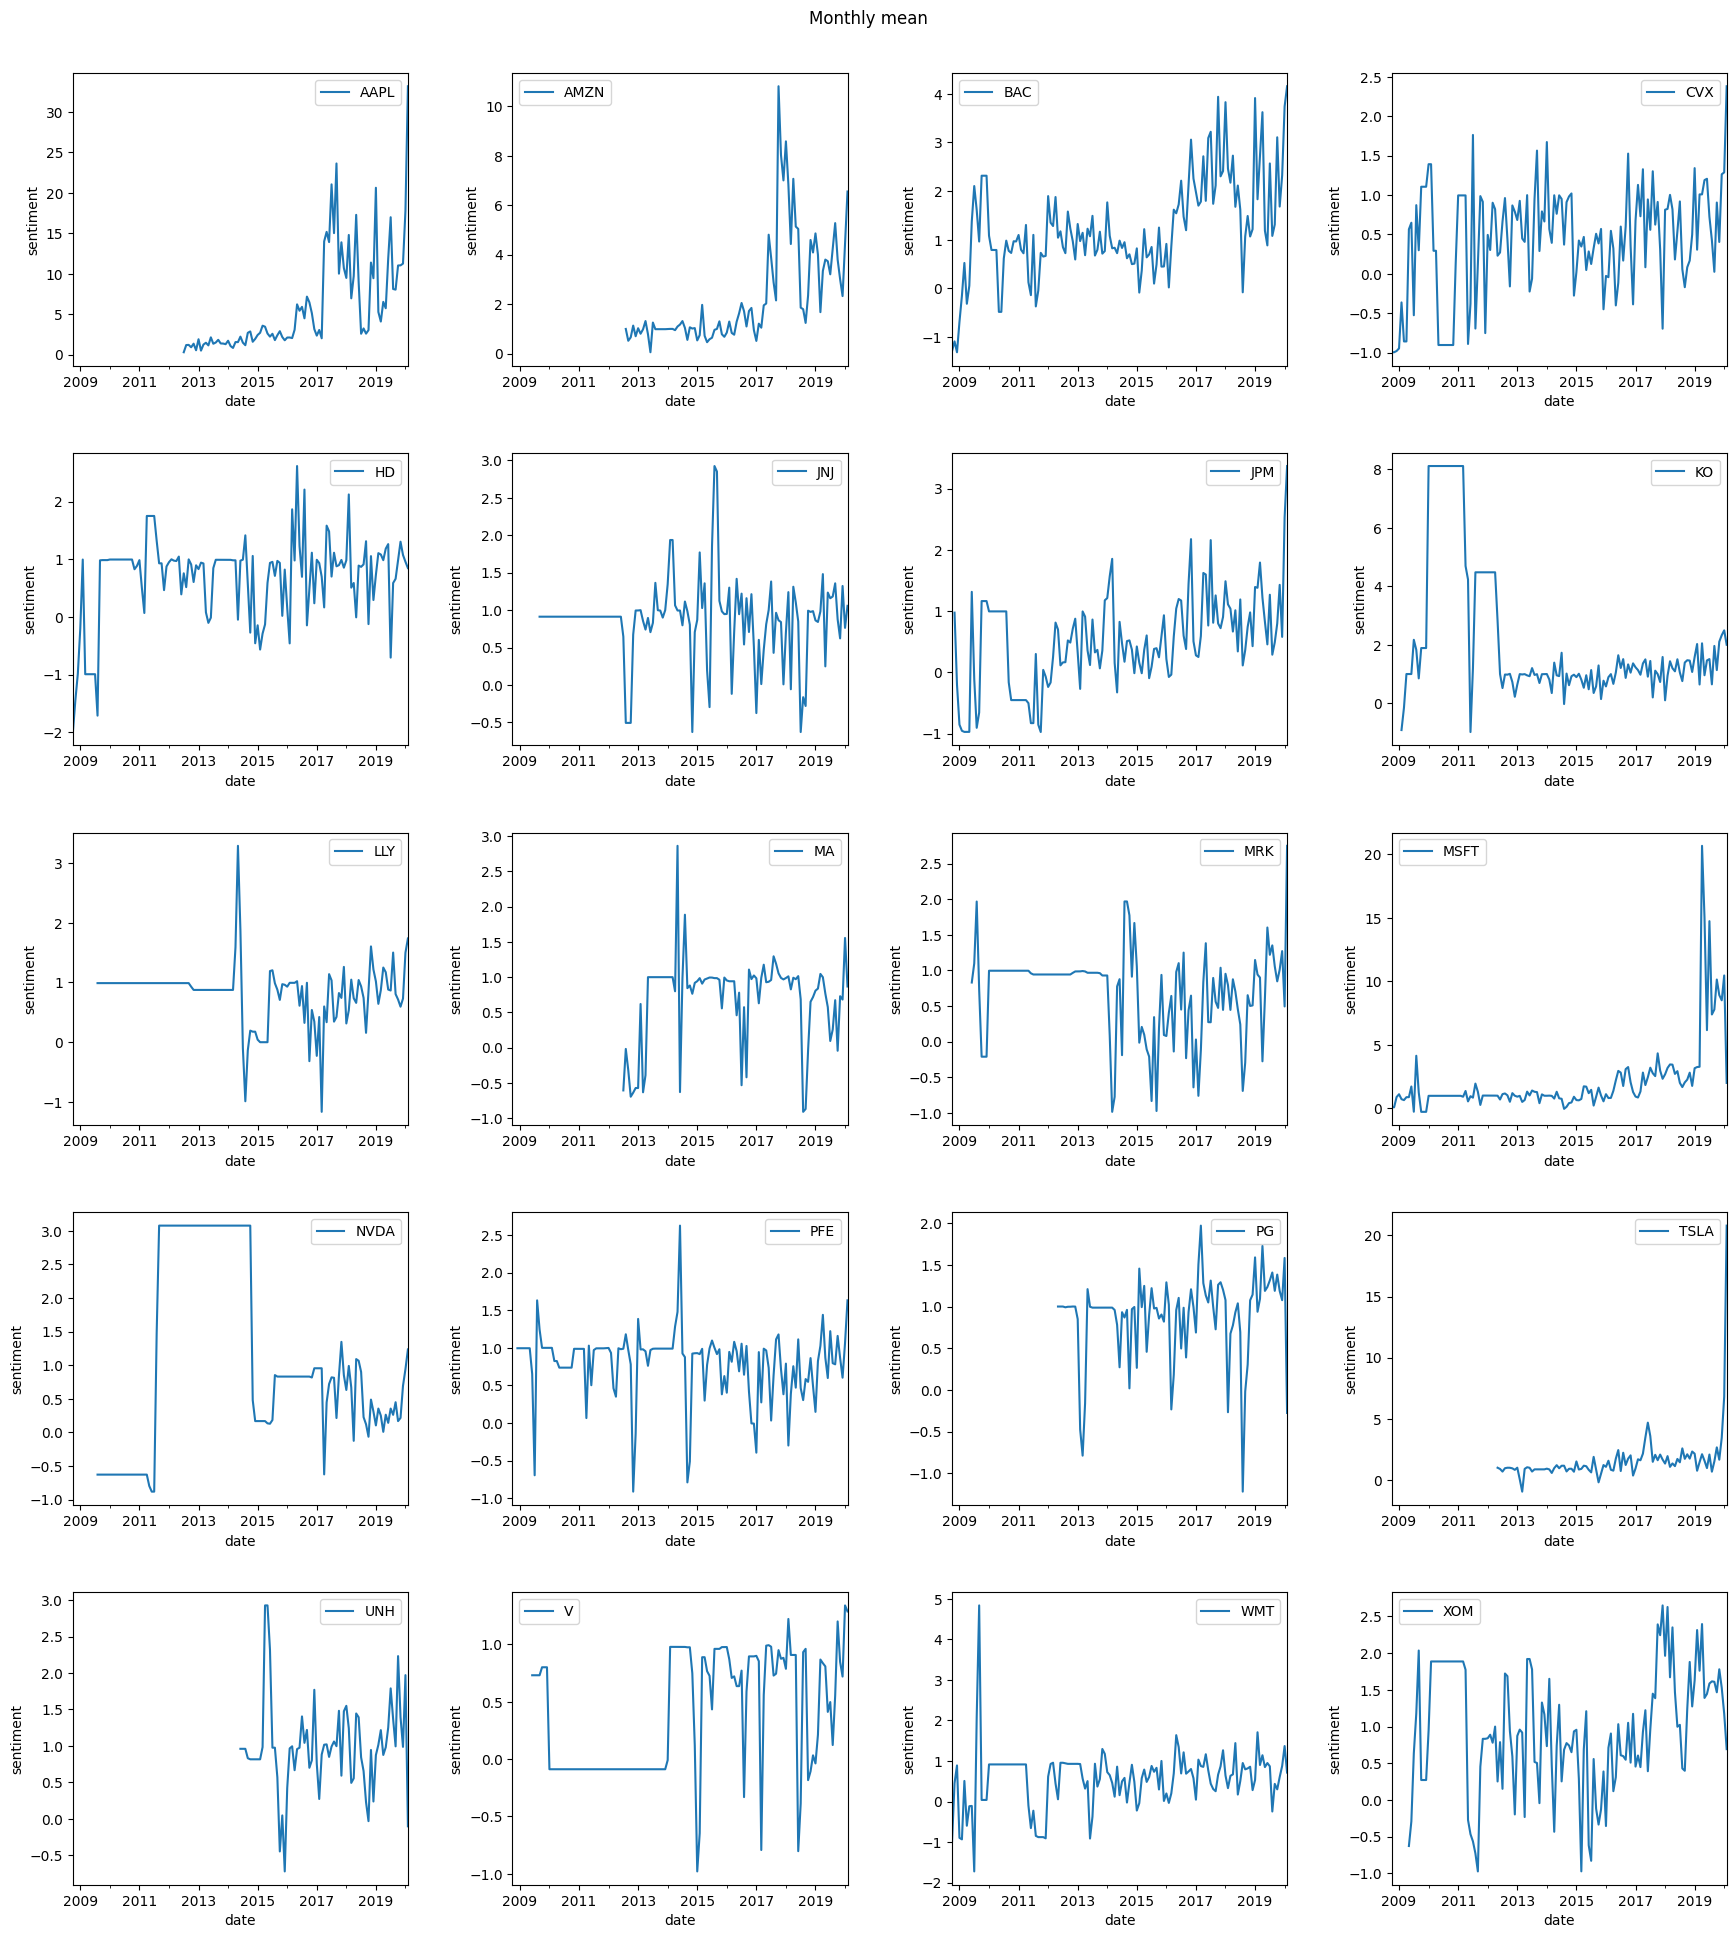

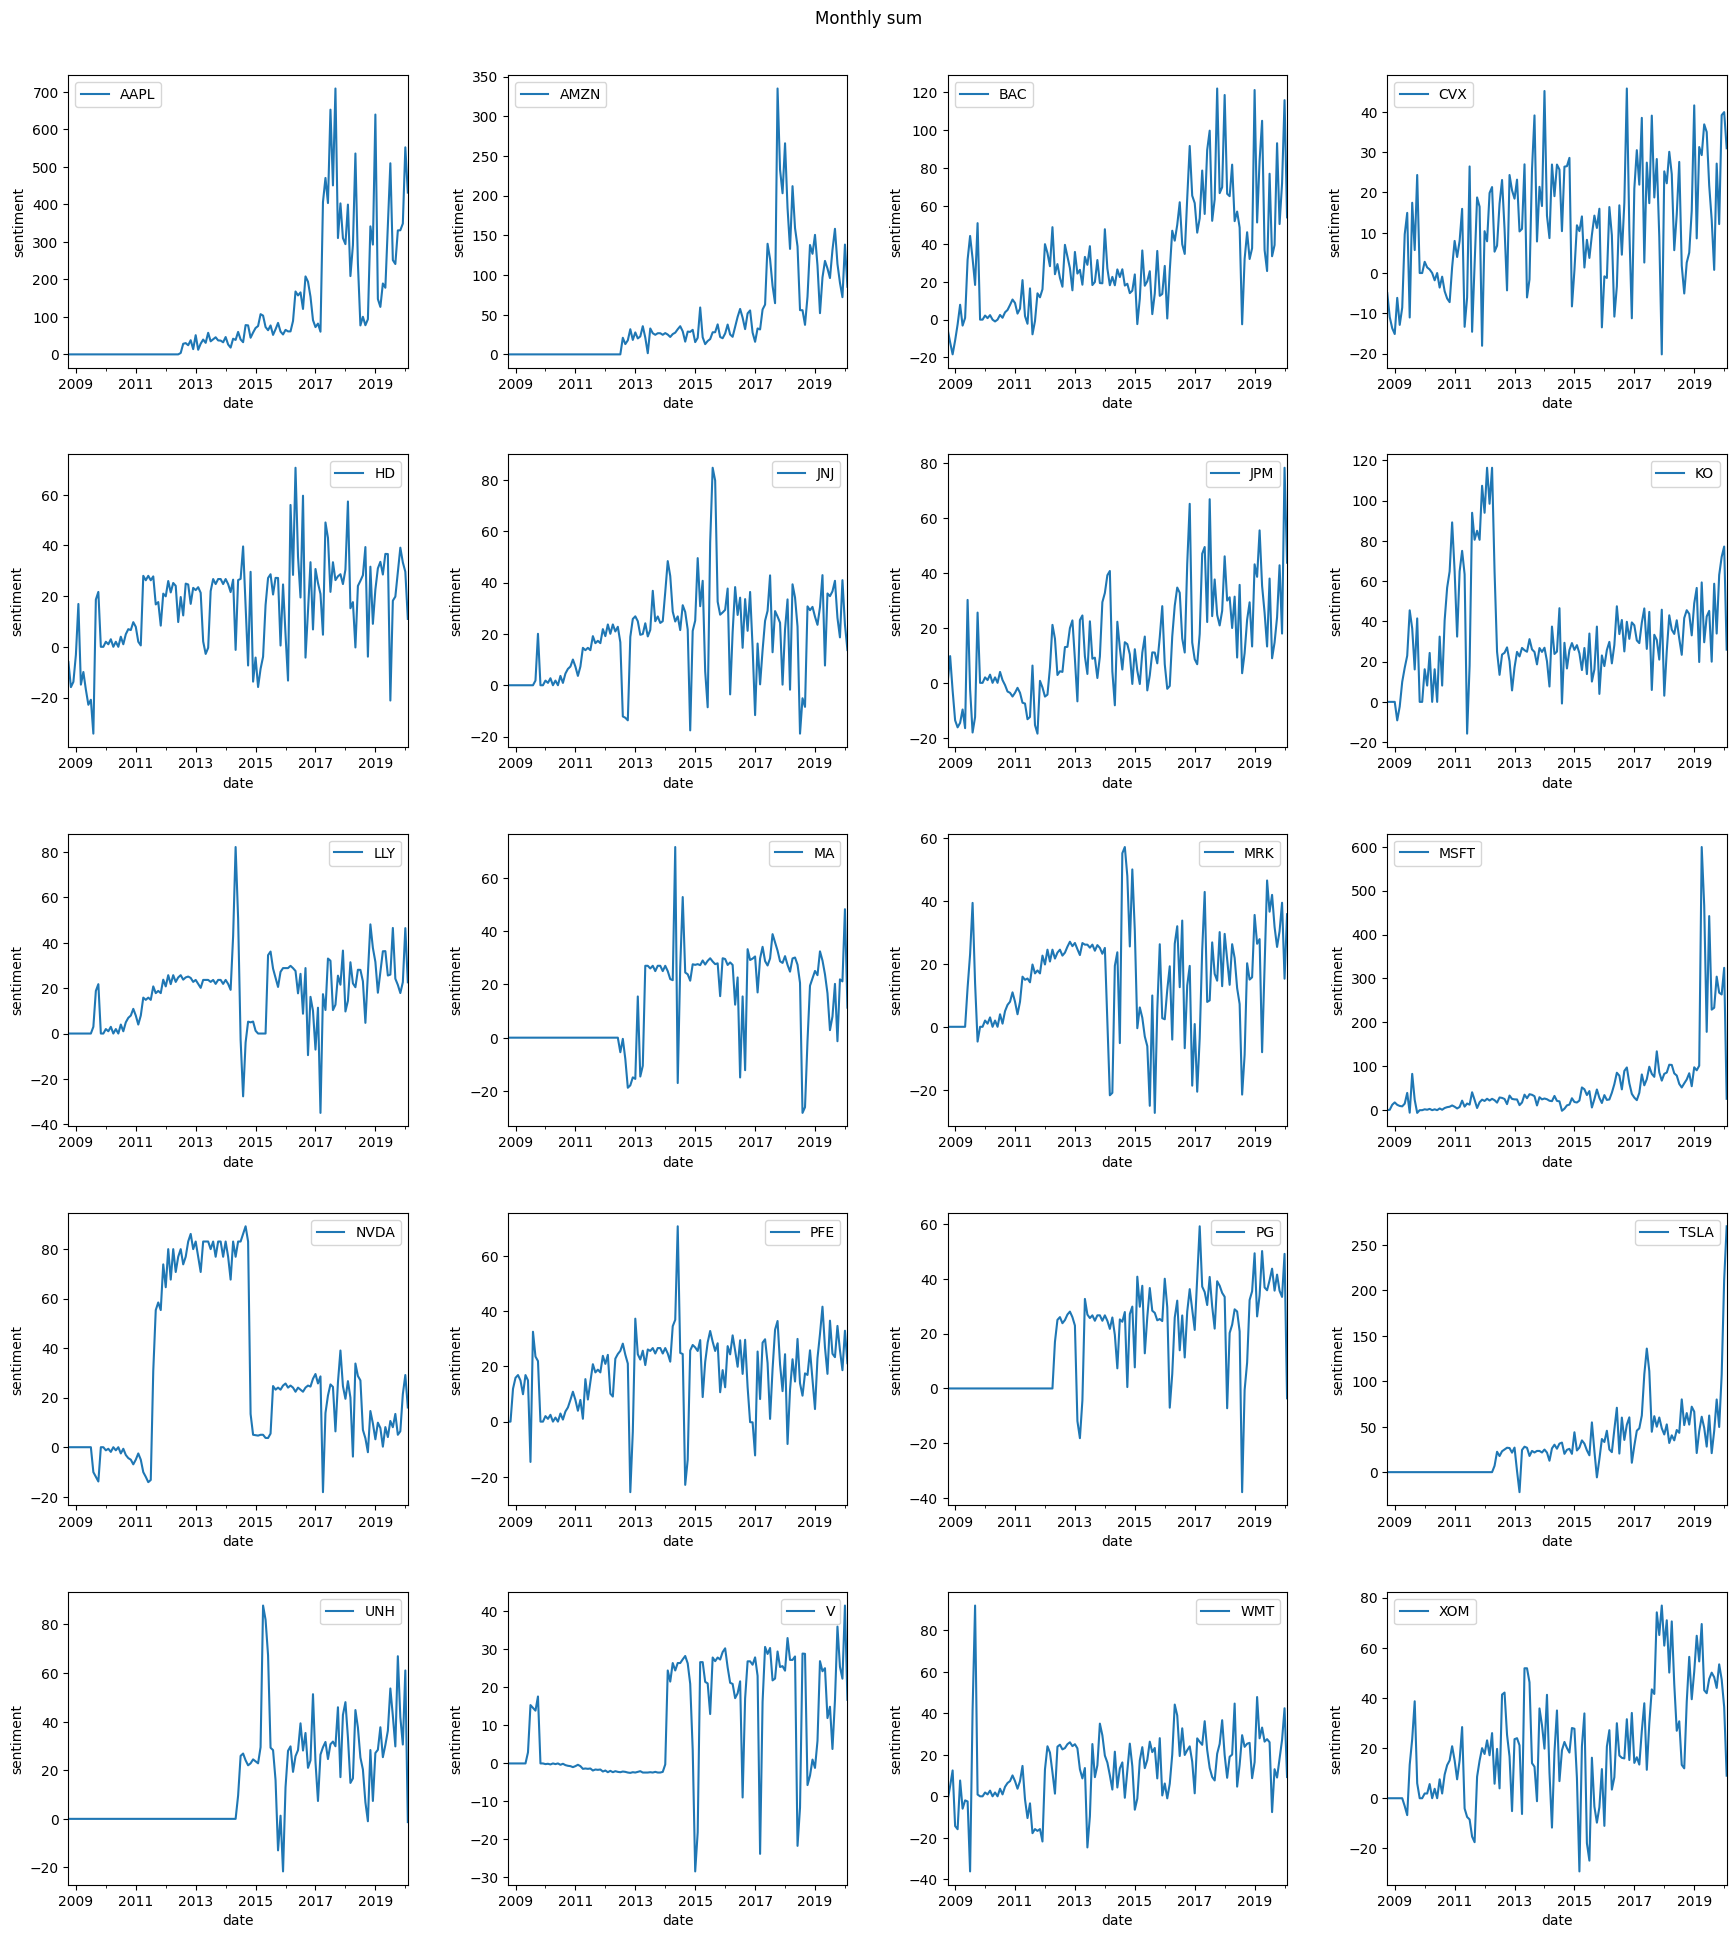

In [384]:
plot_sentiment(monthly_average_df, "Monthly mean")
plot_sentiment(monthly_sum_df, "Monthly sum")

To smooth the data we can calulate a running mean.

In [385]:
def CMA_monthly(ticker, df, N):
    """
    Take the monthly average of the sentiment values.

    ticker_df: pd.DataFrame with dates (dt.datetime) and sentiments values.

    Returns a list of the new dates where the days are set to 1 and a list
    of the monthly average sentiment values.
    """
    average_sentiments = []
    df = df[df[ticker].notna()]
    first_date = df.index[0]
    current_month = first_date.month
    months = [pd.Timestamp(first_date.year, first_date.month, 1)]
    sentiments = [df[ticker].iloc[0]]
    n_months = 0

    for date, row in df.iterrows():
        sentiments.append(row[ticker])

        if date.month != current_month:
            n_months += 1
            months.append(pd.Timestamp(date.year, date.month, 1))
            average_sentiments.append(np.mean(sentiments))
            current_month = date.month

        if n_months == N:
            sentiments = []
            n_months = 0

    average_sentiments.append(np.mean(sentiments))

    return months, average_sentiments

Example of what the smoothing would look like:

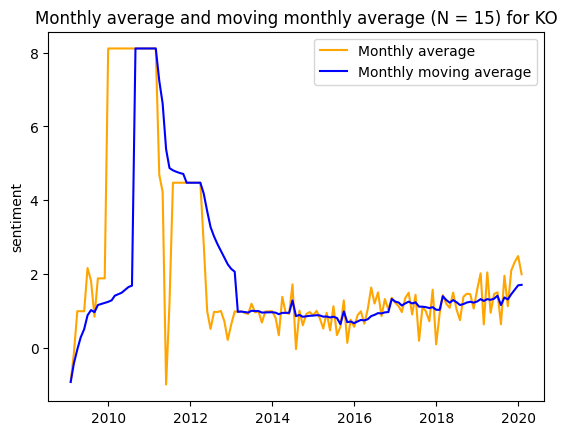

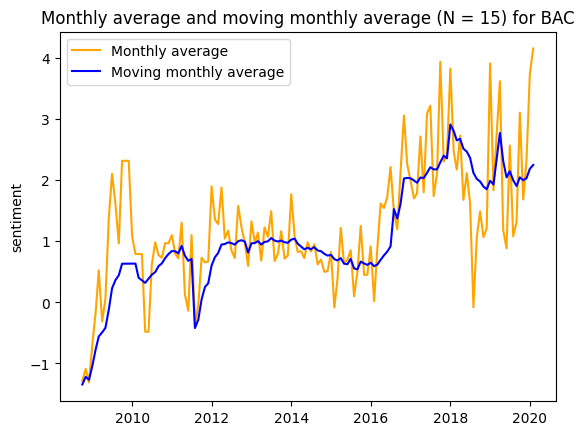

In [386]:
N = 15
months, average_sentiments = CMA_monthly("KO", sentiment_df, N)

plt.plot(monthly_average_df.index, monthly_average_df["KO"], color = "orange", label = "Monthly average")
plt.plot(months, average_sentiments, color = "blue", label = "Monthly moving average")
plt.ylabel("sentiment")
plt.title(f"Monthly average and moving monthly average (N = {N}) for KO")
plt.legend()
plt.show()

months, average_sentiments = CMA_monthly("BAC", sentiment_df, 15)

plt.plot(monthly_average_df.index, monthly_average_df["BAC"], color = "orange", label = "Monthly average")
plt.plot(months, average_sentiments, color = "blue", label = "Moving monthly average")
plt.ylabel("sentiment")
plt.legend()
plt.title(f"Monthly average and moving monthly average (N = {N}) for BAC")
plt.show()

Put the mean and sum in one dataframe

In [387]:
for ticker in monthly_average_df.columns:
    monthly_average_df = monthly_average_df.rename(columns = {f"{ticker}": f"{ticker}_mean"})
    monthly_sum_df = monthly_sum_df.rename(columns = {f"{ticker}": f"{ticker}_sum"})

sentiment_monthly_df = pd.concat([monthly_average_df, monthly_sum_df], axis =1)
sentiment_monthly_df

ticker,AAPL_mean,AMZN_mean,BAC_mean,CVX_mean,HD_mean,JNJ_mean,JPM_mean,KO_mean,LLY_mean,MA_mean,...,MRK_sum,MSFT_sum,NVDA_sum,PFE_sum,PG_sum,TSLA_sum,UNH_sum,V_sum,WMT_sum,XOM_sum
release_date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,NaN,NaN,-1.284100,-0.994900,-1.997100,NaN,NaN,NaN,NaN,NaN,...,0.0000,0.2313,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.9434,0.0000
2008-11-01,NaN,NaN,-1.087973,-0.994900,-1.446191,NaN,0.975100,NaN,NaN,NaN,...,0.0000,0.8481,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.9639,0.0000
2008-12-01,NaN,NaN,-1.310829,-0.979186,-0.987100,NaN,-0.200621,NaN,NaN,NaN,...,0.0000,12.3391,0.0000,11.9196,0.0000,0.0000,0.0000,0.0000,12.4716,0.0000
2009-01-01,NaN,NaN,-0.688887,-0.946000,-0.198750,NaN,-0.853800,NaN,NaN,NaN,...,0.0000,17.6375,0.0000,15.8928,0.0000,0.0000,0.0000,0.0000,-14.3301,0.0000
2009-02-01,NaN,NaN,-0.149082,-0.362529,0.994112,NaN,-0.954271,-0.918600,NaN,NaN,...,0.0000,12.1554,0.0000,16.8861,0.0000,0.0000,0.0000,0.0000,-15.8666,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,11.015843,3.798560,3.106277,0.905090,0.976417,0.876693,0.797437,1.131810,0.714310,-0.044513,...,25.3489,304.0993,5.0134,34.7124,41.4741,79.9183,66.9384,36.0180,9.0314,43.9887
2019-11-01,11.032180,3.008040,1.682893,0.404740,1.303360,0.622123,1.428737,2.101870,0.594477,0.729353,...,30.3177,267.4509,6.4411,25.9376,35.5896,49.6561,41.8267,25.4417,18.1494,53.3816
2019-12-01,11.246571,2.325113,2.321423,1.263490,1.074171,1.321790,0.579365,2.325187,0.729668,0.681568,...,39.3699,263.5291,21.4187,18.6511,33.3546,107.0520,30.5897,22.3090,27.1922,47.3539


Add the running mean with N = 15 to this dataframe

In [388]:
for ticker in sentiment_df.columns:
    sentiment_monthly_df[f"{ticker}_run_mean"] = float("nan")
    months, average_sentiments = CMA_monthly(ticker, sentiment_df, 15)
    for month, average_sentiment in zip(months, average_sentiments):
        sentiment_monthly_df.loc[month, f"{ticker}_run_mean"] = average_sentiment

sentiment_monthly_df = sentiment_monthly_df.reindex(sorted(sentiment_monthly_df.columns), axis=1)
sentiment_monthly_df = sentiment_monthly_df.fillna(method="ffill")
sentiment_monthly_df

ticker,AAPL_mean,AAPL_run_mean,AAPL_sum,AMZN_mean,AMZN_run_mean,AMZN_sum,BAC_mean,BAC_run_mean,BAC_sum,CVX_mean,...,UNH_sum,V_mean,V_run_mean,V_sum,WMT_mean,WMT_run_mean,WMT_sum,XOM_mean,XOM_run_mean,XOM_sum
release_date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,NaN,NaN,0.0000,NaN,NaN,0.0000,-1.284100,-1.344317,-5.1364,-0.994900,...,0.0000,NaN,NaN,0.0000,-0.971700,-0.971700,-1.9434,NaN,NaN,0.0000
2008-11-01,NaN,NaN,0.0000,NaN,NaN,0.0000,-1.087973,-1.220112,-11.9677,-0.994900,...,0.0000,NaN,NaN,0.0000,0.451264,0.203067,4.9639,NaN,NaN,0.0000
2008-12-01,NaN,NaN,0.0000,NaN,NaN,0.0000,-1.310829,-1.267923,-18.3516,-0.979186,...,0.0000,NaN,NaN,0.0000,0.890829,0.522252,12.4716,NaN,NaN,0.0000
2009-01-01,NaN,NaN,0.0000,NaN,NaN,0.0000,-0.688887,-1.040223,-11.0222,-0.946000,...,0.0000,NaN,NaN,0.0000,-0.895631,-0.017927,-14.3301,NaN,NaN,0.0000
2009-02-01,NaN,NaN,0.0000,NaN,NaN,0.0000,-0.149082,-0.765978,-2.5344,-0.362529,...,0.0000,NaN,NaN,0.0000,-0.933329,-0.251466,-15.8666,NaN,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,11.015843,9.403773,330.4753,3.798560,3.781883,113.9568,3.106277,2.046701,93.1883,0.905090,...,66.9384,1.200600,1.182347,36.0180,0.301047,0.759813,9.0314,1.466290,1.690427,43.9887
2019-11-01,11.032180,9.518424,330.9654,3.008040,3.722480,90.2412,1.682893,2.000032,50.4868,0.404740,...,41.8267,0.848057,1.011918,25.4417,0.604980,0.741074,18.1494,1.779387,1.629297,53.3816
2019-12-01,11.246571,9.637602,348.6437,2.325113,3.620067,72.0785,2.321423,2.030720,71.9641,1.263490,...,30.5897,0.719645,0.907797,22.3090,0.877168,0.753858,27.1922,1.527545,1.611318,47.3539


In [389]:
def plot_run_mean(df):
    fig = plt.figure(figsize= (18, 20))
    j = 0
    for column in df.columns:
        if "_run_mean" in column:
            j+=1
            plt.subplot(5, 4, j)
            df[column].plot(label = column)
            plt.ylabel("sentiment")
            plt.xlabel("date")
            plt.legend()

    plt.suptitle("Running monthly mean")
    fig.tight_layout(pad = 3)
    plt.show()

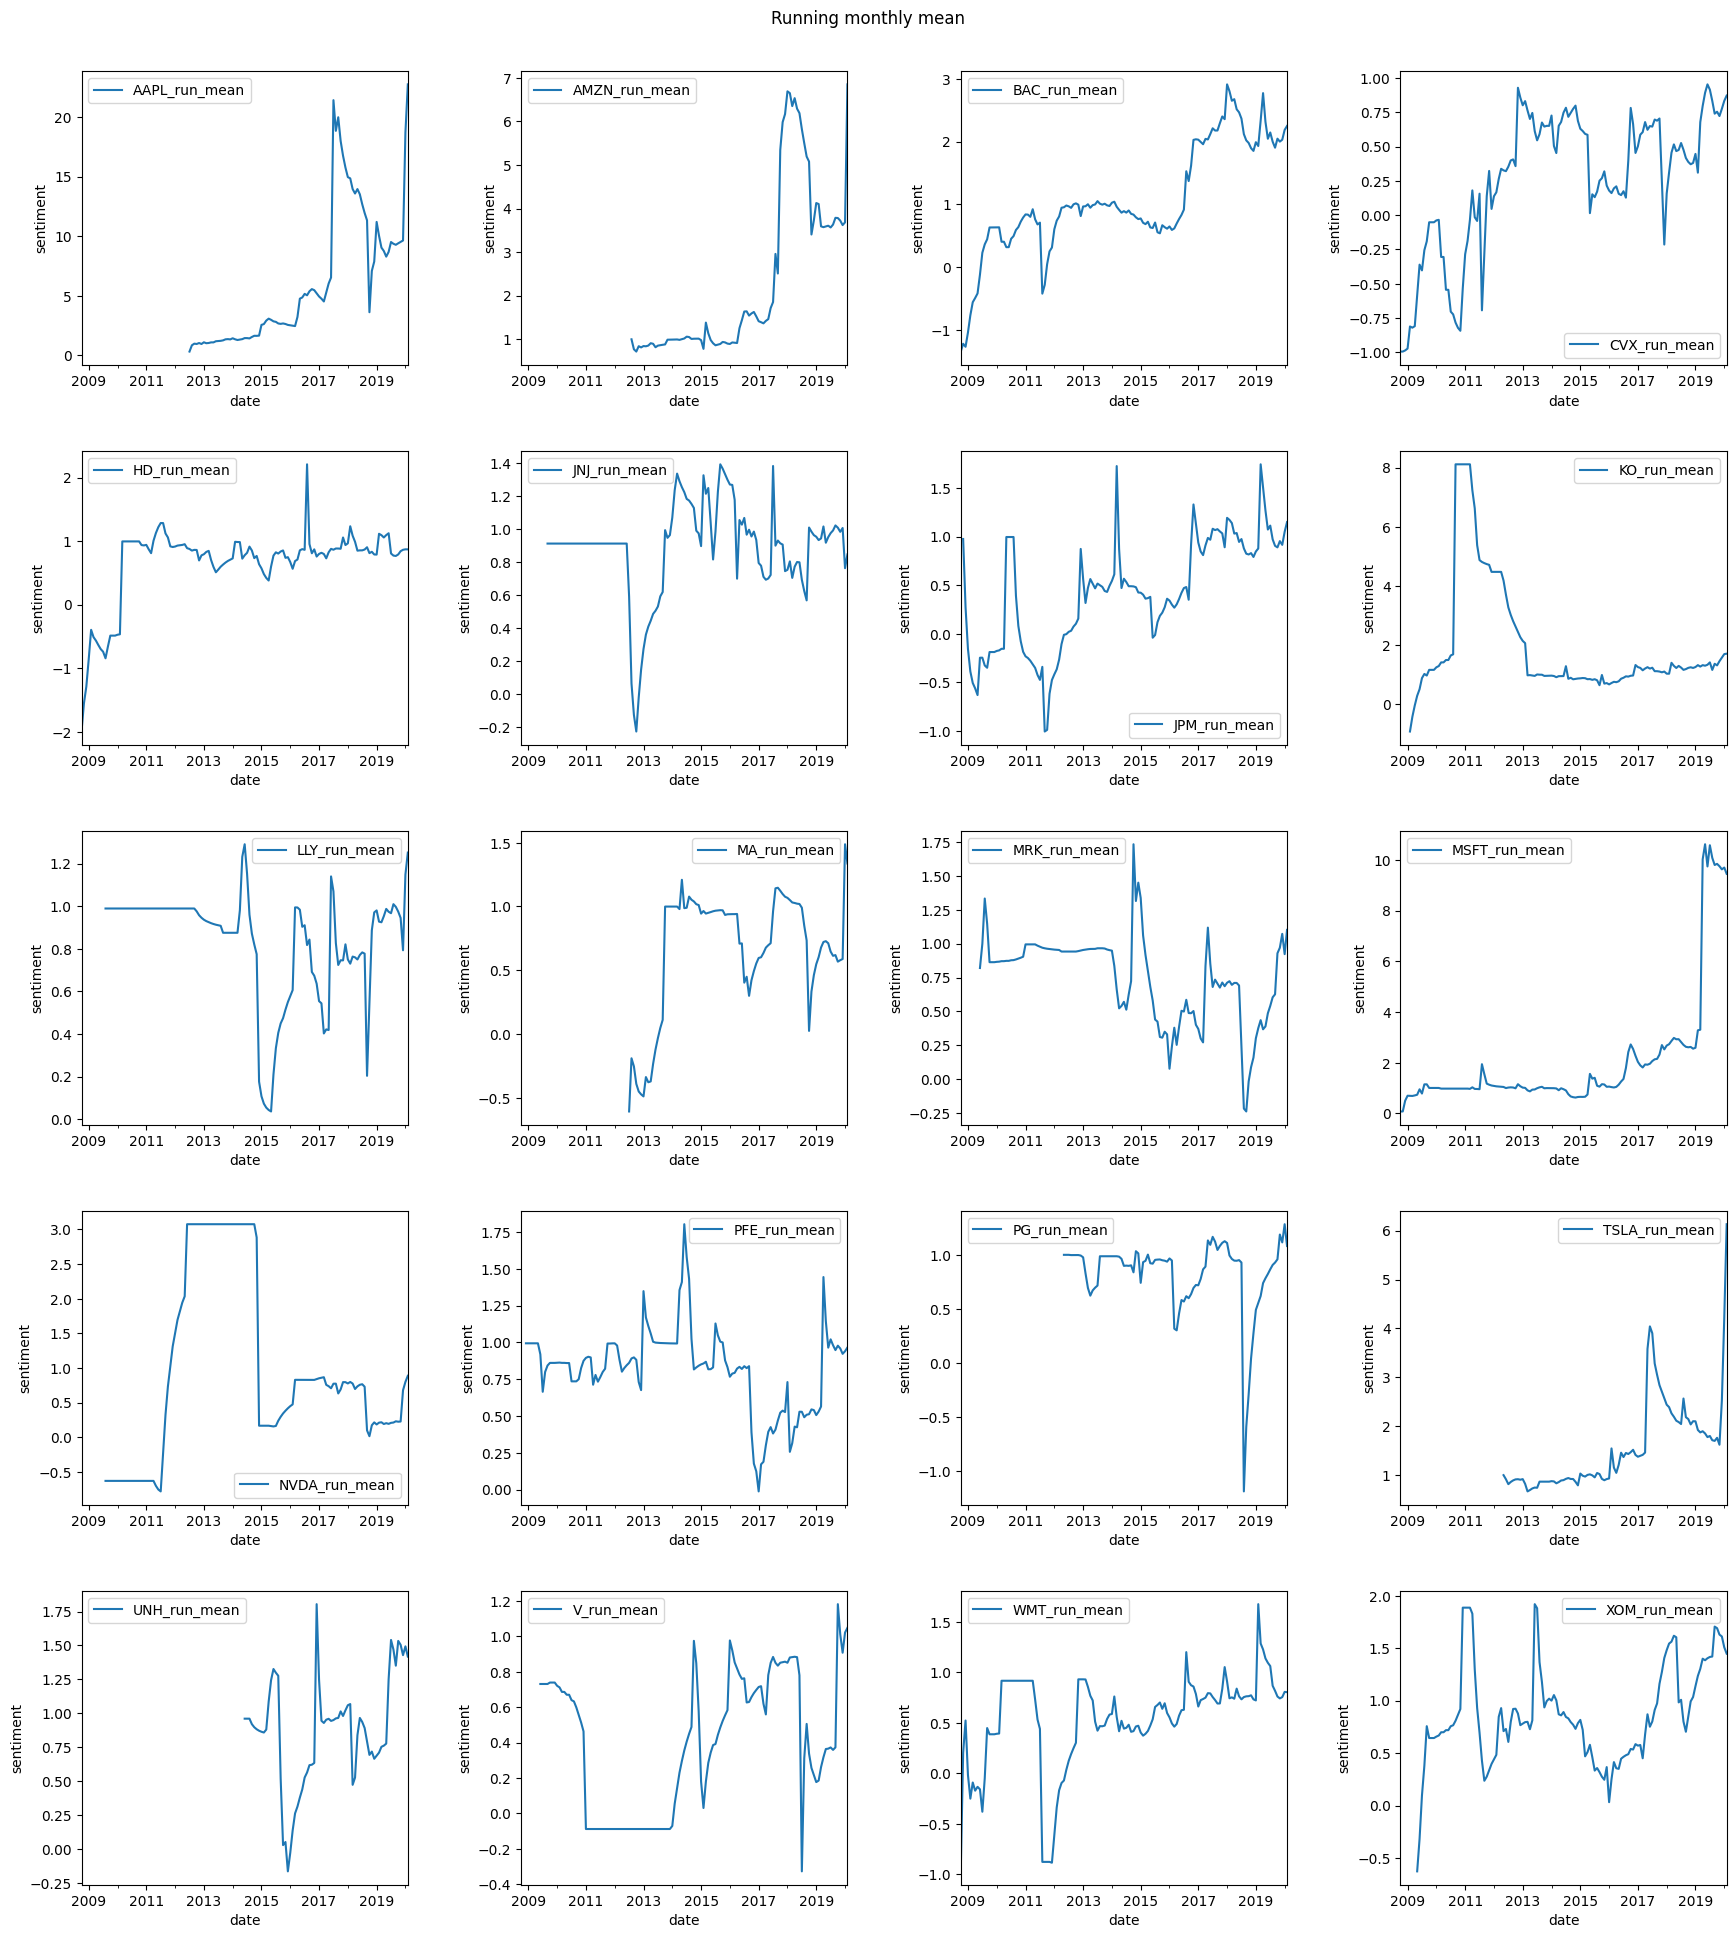

In [390]:
plot_run_mean(sentiment_monthly_df)

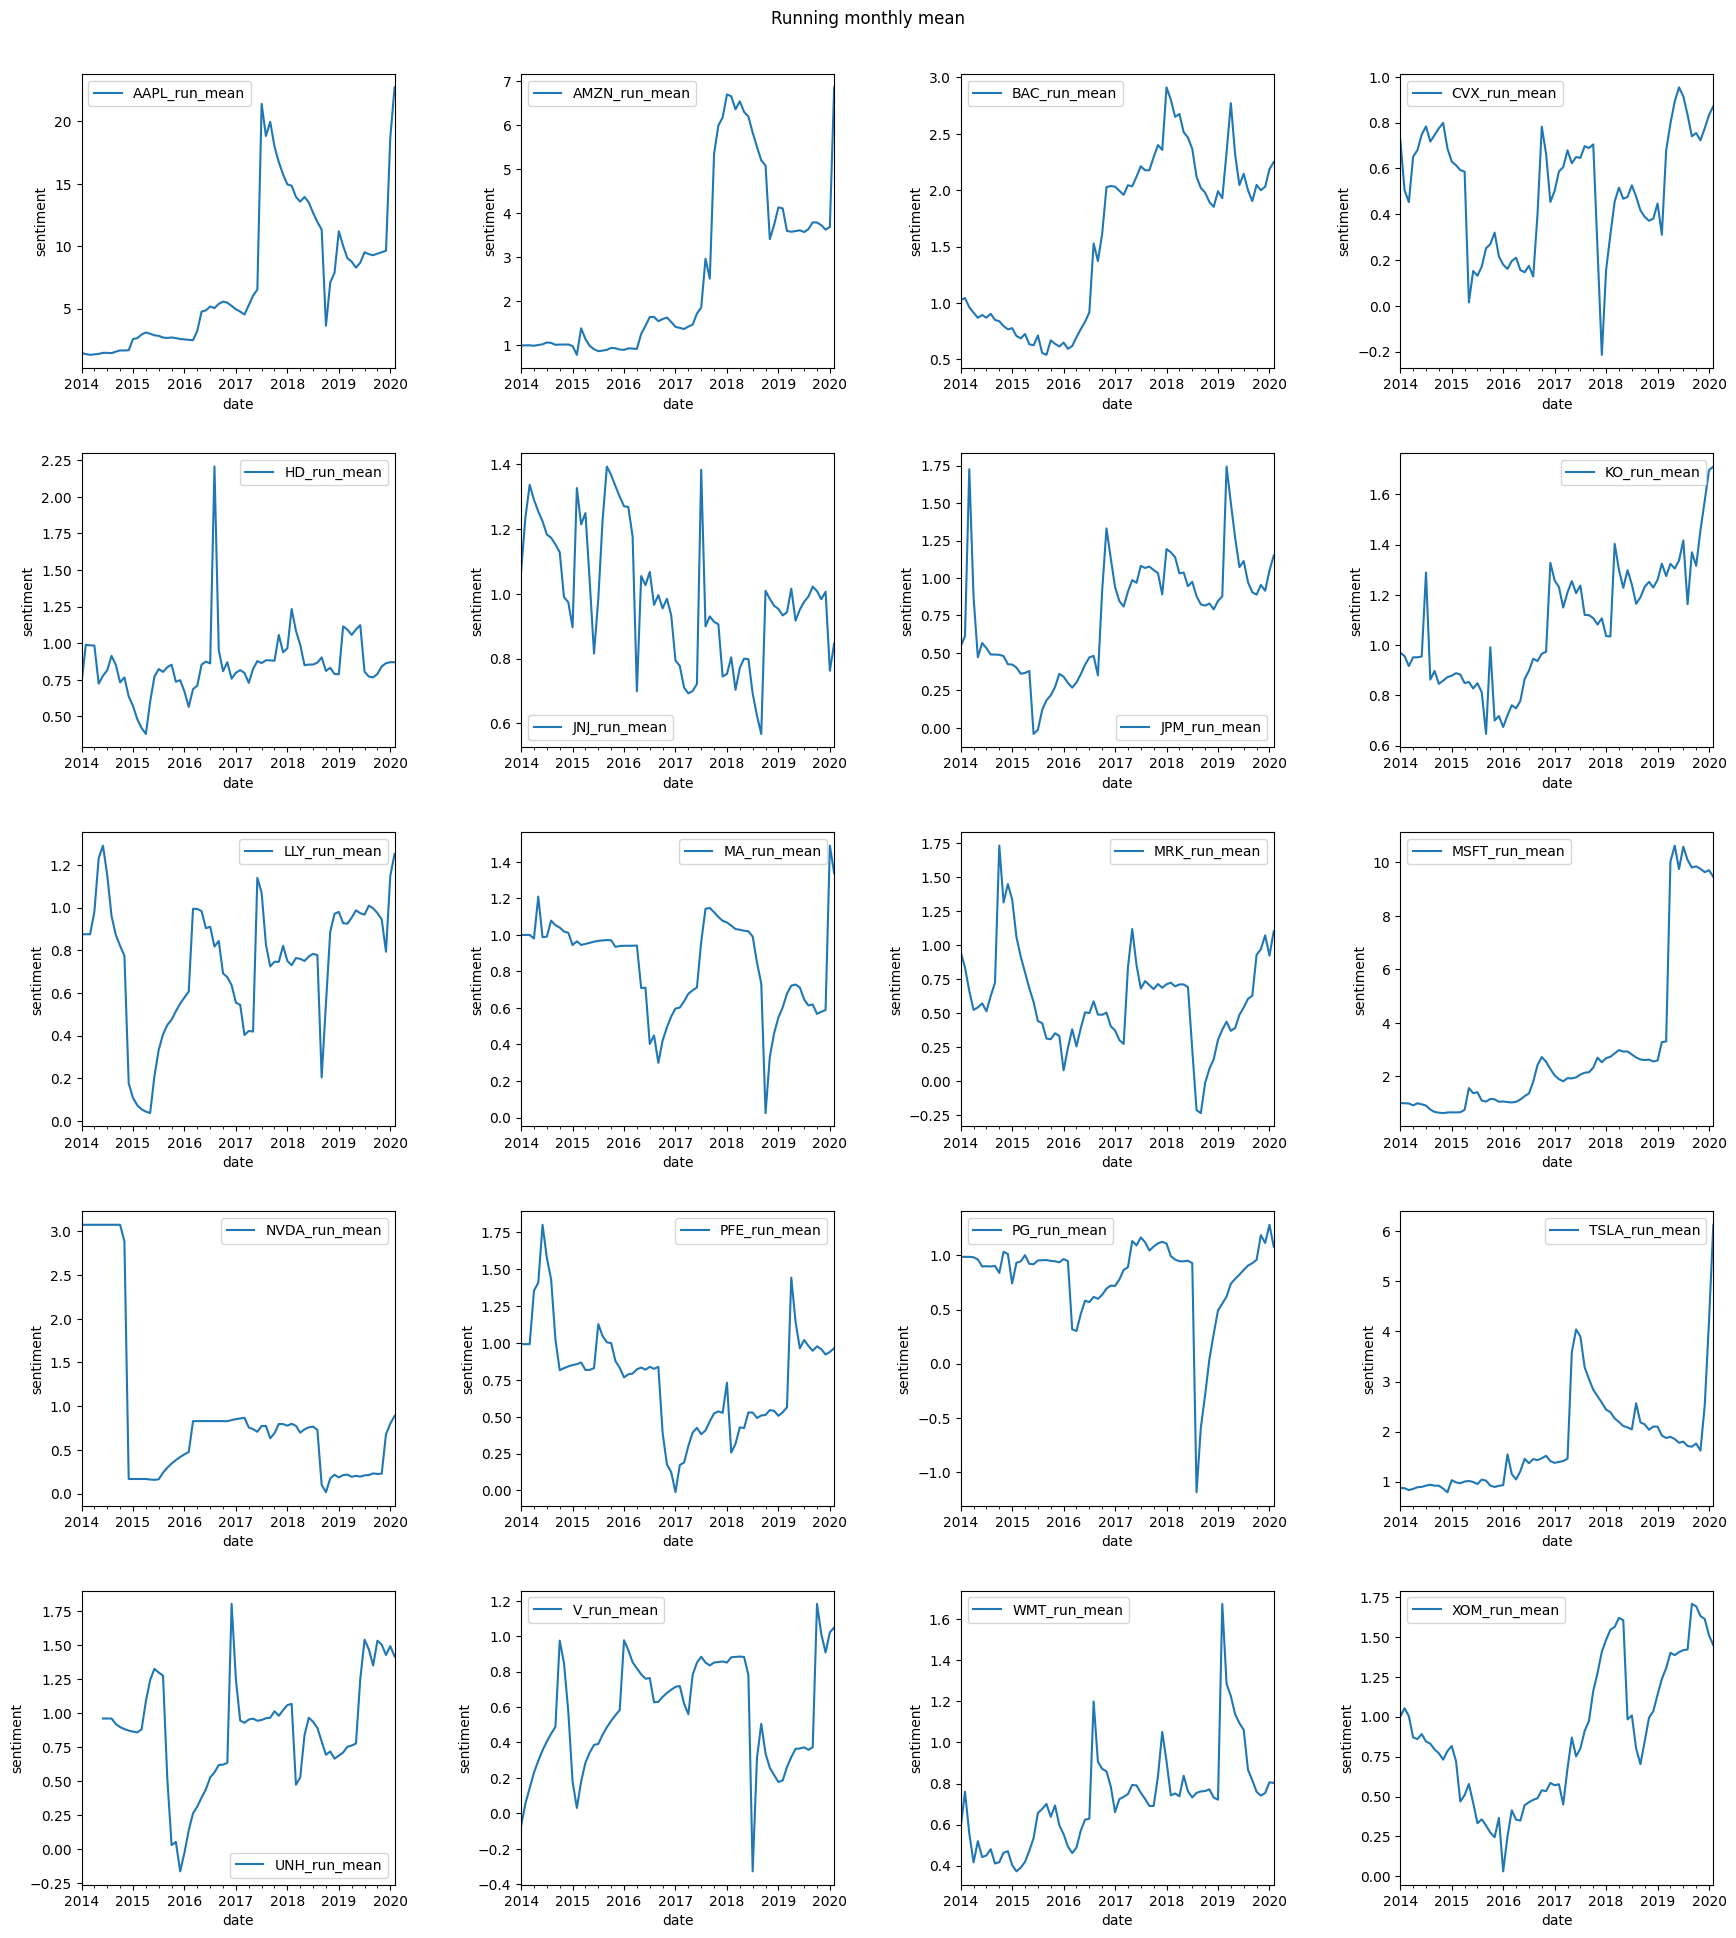

In [391]:
sentiment_monthly_df = sentiment_monthly_df[sentiment_monthly_df.index >= pd.to_datetime('2014-01-01')]
plot_run_mean(sentiment_monthly_df)

The stocks in high to low order of sentiment data:

In [392]:
stocks = pd.read_csv(pathlib.Path("../data/used_companies.csv"))
stocks

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE,LLY,NVDA,MA,UNH,V


Throwing away the data of the 5 stocks with the least amount of sentiment data: V, UNH, MA, NVDA and LLY. We can observe in the above graph that these stocks do not look great (blocky / a lot of straight lines).

In [393]:
def delete(stock):
    del sentiment_monthly_df[f"{stock}_mean"]
    del sentiment_monthly_df[f"{stock}_sum"]
    del sentiment_monthly_df[f"{stock}_run_mean"]
    del stocks[f"{stock}"]
    del sentiment_df[f"{stock}"]

In [394]:
delete_list = ["LLY", "NVDA", "MA", "UNH", "V"]
for stock in delete_list:
    delete(stock)

# ADF Tests

In [395]:
def stationary(data, variable) -> bool:
    """
    Test stationarity with augmented Dickey Fuller test. Testing the following hypothesis with
    the resulting p-value:

    H0: The data has a unit root and is stationary.

    Returns true if stationary else return false
    """

    print(f"Output results augmented Dickey Fuller test for variable: {variable}")
    results_augmented_dickey_fuller = adfuller(data)
    print('ADF Statistic: %f' % results_augmented_dickey_fuller[0])
    print('p-value: %f' % results_augmented_dickey_fuller[1])
    print('Critical Values:')
    for key, value in results_augmented_dickey_fuller[4].items():
        print('\t%s: %.3f' % (key, value))

    if results_augmented_dickey_fuller[1] <= 0.05:
        print("Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary")
        print('\n')
        return True
    else:
        print("Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary")
        print('\n')
        return False

In [396]:
def check_stationarity(sentiment_monthly_df, column):
    not_stationary_tickers = []

    for ticker in stocks:
        if not stationary(sentiment_monthly_df[f"{ticker}_{column}"], ticker):
            not_stationary_tickers.append(ticker)

    return not_stationary_tickers

## Monthly data ADF tests

In [397]:
check_stationarity(sentiment_monthly_df, "mean")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -1.333330
p-value: 0.613789
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: 1.206019
p-value: 0.996027
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -1.473906
p-value: 0.546378
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -2.822705
p-value: 0.055103
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Conclusi

['AAPL', 'MSFT', 'BAC', 'AMZN', 'TSLA', 'XOM', 'KO']

In [398]:
check_stationarity(sentiment_monthly_df, "sum")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -2.340131
p-value: 0.159351
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: 1.137060
p-value: 0.995521
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -1.424628
p-value: 0.570414
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -1.884105
p-value: 0.339575
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusi

['AAPL', 'MSFT', 'BAC', 'AMZN', 'TSLA', 'XOM', 'JPM', 'KO']

The stocks above are not stationary for the sum of the sentiment

In [399]:
check_stationarity(sentiment_monthly_df, "run_mean")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -0.968714
p-value: 0.764503
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -0.245153
p-value: 0.932921
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -1.234260
p-value: 0.658687
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -0.491324
p-value: 0.893698
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Conclus

['AAPL',
 'MSFT',
 'BAC',
 'AMZN',
 'TSLA',
 'XOM',
 'JPM',
 'KO',
 'CVX',
 'MRK',
 'PFE']

Stocks above are not stationary for the running mean

## Making monthly data stationary

To make the time series stationary we can compute the deratitive by taking the percentage differences.

In [400]:
pd.options.mode.chained_assignment = None
for column in sentiment_monthly_df:
    sentiment_monthly_df.loc[:,f"{column}_diff"] = sentiment_monthly_df.loc[:,column].astype(float).diff()

sentiment_monthly_df = sentiment_monthly_df.reindex(sorted(sentiment_monthly_df.columns), axis=1)
sentiment_monthly_df


ticker,AAPL_mean,AAPL_mean_diff,AAPL_run_mean,AAPL_run_mean_diff,AAPL_sum,AAPL_sum_diff,AMZN_mean,AMZN_mean_diff,AMZN_run_mean,AMZN_run_mean_diff,...,WMT_run_mean,WMT_run_mean_diff,WMT_sum,WMT_sum_diff,XOM_mean,XOM_mean_diff,XOM_run_mean,XOM_run_mean_diff,XOM_sum,XOM_sum_diff
release_date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,1.712444,NaN,1.437526,NaN,46.2360,NaN,0.993578,NaN,0.989389,NaN,...,0.586734,NaN,19.6169,NaN,0.732378,NaN,0.999573,NaN,19.7742,NaN
2014-02-01,1.054720,-0.657724,1.352094,-0.085433,26.3680,-19.8680,0.998100,4.522222e-03,0.991483,0.002094,...,0.760048,0.173314,16.2769,-3.3400,1.649540,0.917162,1.052647,0.053074,41.2385,21.4643
2014-03-01,0.820264,-0.234456,1.292475,-0.059619,18.0458,-8.3222,0.998100,-1.110223e-16,0.992638,0.001155,...,0.556930,-0.203118,10.1258,-6.1511,0.466573,-1.182967,1.002690,-0.049957,10.2646,-30.9739
2014-04-01,1.546404,0.726140,1.330788,0.038313,41.7529,23.7071,0.947463,-5.063704e-02,0.983218,-0.009420,...,0.415651,-0.141278,3.2438,-6.8820,-0.433622,-0.900195,0.869560,-0.133130,-11.7078,-21.9724
2014-05-01,1.540248,-0.006156,1.365112,0.034324,38.5062,-3.2467,1.094200,1.467370e-01,1.000008,0.016790,...,0.519251,0.103599,21.5195,18.2757,0.735624,1.169246,0.859292,-0.010268,18.3906,30.0984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,11.015843,2.985713,9.403773,0.125741,330.4753,89.5714,3.798560,-1.476023e+00,3.781883,-0.004742,...,0.759813,-0.056488,9.0314,-4.0475,1.466290,-0.142667,1.690427,-0.014937,43.9887,-4.2800
2019-11-01,11.032180,0.016337,9.518424,0.114651,330.9654,0.4901,3.008040,-7.905200e-01,3.722480,-0.059403,...,0.741074,-0.018739,18.1494,9.1180,1.779387,0.313097,1.629297,-0.061130,53.3816,9.3929
2019-12-01,11.246571,0.214391,9.637602,0.119178,348.6437,17.6783,2.325113,-6.829271e-01,3.620067,-0.102413,...,0.753858,0.012784,27.1922,9.0428,1.527545,-0.251842,1.611318,-0.017978,47.3539,-6.0277


In [401]:
sentiment_monthly_df = sentiment_monthly_df.fillna(method="ffill")
sentiment_monthly_df.replace([np.inf, -np.inf, "inf", np.NaN], 0, inplace=True)
sentiment_monthly_df = sentiment_monthly_df.drop(sentiment_monthly_df.index[0])

In [402]:
sentiment_monthly_df

ticker,AAPL_mean,AAPL_mean_diff,AAPL_run_mean,AAPL_run_mean_diff,AAPL_sum,AAPL_sum_diff,AMZN_mean,AMZN_mean_diff,AMZN_run_mean,AMZN_run_mean_diff,...,WMT_run_mean,WMT_run_mean_diff,WMT_sum,WMT_sum_diff,XOM_mean,XOM_mean_diff,XOM_run_mean,XOM_run_mean_diff,XOM_sum,XOM_sum_diff
release_date,,,,,,,,,,,,,,,,,,,,,
2014-02-01,1.054720,-0.657724,1.352094,-0.085433,26.3680,-19.8680,0.998100,4.522222e-03,0.991483,0.002094,...,0.760048,0.173314,16.2769,-3.3400,1.649540,0.917162,1.052647,0.053074,41.2385,21.4643
2014-03-01,0.820264,-0.234456,1.292475,-0.059619,18.0458,-8.3222,0.998100,-1.110223e-16,0.992638,0.001155,...,0.556930,-0.203118,10.1258,-6.1511,0.466573,-1.182967,1.002690,-0.049957,10.2646,-30.9739
2014-04-01,1.546404,0.726140,1.330788,0.038313,41.7529,23.7071,0.947463,-5.063704e-02,0.983218,-0.009420,...,0.415651,-0.141278,3.2438,-6.8820,-0.433622,-0.900195,0.869560,-0.133130,-11.7078,-21.9724
2014-05-01,1.540248,-0.006156,1.365112,0.034324,38.5062,-3.2467,1.094200,1.467370e-01,1.000008,0.016790,...,0.519251,0.103599,21.5195,18.2757,0.735624,1.169246,0.859292,-0.010268,18.3906,30.0984
2014-06-01,2.218952,0.678704,1.452438,0.087326,59.9117,21.4055,1.174026,7.982593e-02,1.015107,0.015099,...,0.441900,-0.077351,4.2398,-17.2797,1.296226,0.560602,0.890709,0.031417,34.9981,16.6075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,11.015843,2.985713,9.403773,0.125741,330.4753,89.5714,3.798560,-1.476023e+00,3.781883,-0.004742,...,0.759813,-0.056488,9.0314,-4.0475,1.466290,-0.142667,1.690427,-0.014937,43.9887,-4.2800
2019-11-01,11.032180,0.016337,9.518424,0.114651,330.9654,0.4901,3.008040,-7.905200e-01,3.722480,-0.059403,...,0.741074,-0.018739,18.1494,9.1180,1.779387,0.313097,1.629297,-0.061130,53.3816,9.3929
2019-12-01,11.246571,0.214391,9.637602,0.119178,348.6437,17.6783,2.325113,-6.829271e-01,3.620067,-0.102413,...,0.753858,0.012784,27.1922,9.0428,1.527545,-0.251842,1.611318,-0.017978,47.3539,-6.0277


Now lets do the ADF test again:

In [403]:
check_stationarity(sentiment_monthly_df, "mean_diff")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -10.752511
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -4.033793
p-value: 0.001244
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -3.897618
p-value: 0.002052
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -8.076932
p-value: 0.000000
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusio

['TSLA', 'CVX']

In [404]:
check_stationarity(sentiment_monthly_df, "run_mean_diff")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -8.506359
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -7.988373
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -3.516693
p-value: 0.007569
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -6.362858
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion

[]

In [405]:
check_stationarity(sentiment_monthly_df, "sum_diff")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -12.643141
p-value: 0.000000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -4.103601
p-value: 0.000955
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -2.404215
p-value: 0.140550
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593
Conclusion: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -9.068536
p-value: 0.000000
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
Conclusi

['BAC', 'CVX']

In [406]:
sentiment_monthly_df.to_csv("../data/sentiment_data.csv")

<AxesSubplot: xlabel='release_date'>

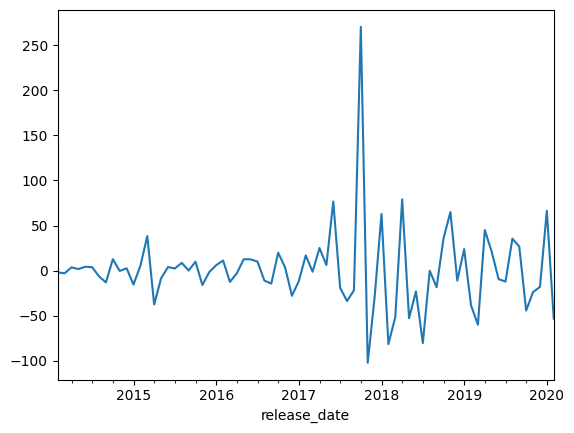

In [407]:
sentiment_monthly_df["AMZN_sum_diff"].plot()

## Daily data ADF test and making stationary

In [408]:
sentiment_df = sentiment_df[sentiment_df.index >= pd.to_datetime('2014-01-01')]
sentiment_df

ticker,AAPL,AMZN,BAC,CVX,HD,JNJ,JPM,KO,MRK,MSFT,PFE,PG,TSLA,WMT,XOM
release_date,,,,,,,,,,,,,,,
2014-01-02,0.9987,0.9870,1.8862,0.5751,0.9900,0.9990,1.9981,0.9997,0.9274,0.9980,0.9881,0.9866,0.8641,0.9135,0.9595
2014-01-03,1.9623,0.9870,1.8862,1.9993,0.9900,0.9990,1.9981,0.9997,0.9274,0.9980,0.9881,0.9866,0.8641,0.9135,0.9595
2014-01-04,0.9747,0.9870,1.8862,1.9993,0.9900,0.9990,1.9981,0.9997,0.9274,0.9980,0.9881,0.9866,0.8641,0.9135,0.9595
2014-01-05,2.6382,0.9870,0.9956,1.9993,0.9900,0.9990,1.9981,0.9963,0.9274,0.9980,0.9881,0.9866,0.8641,0.9135,0.9977
2014-01-06,2.6382,0.9870,0.9956,1.9993,0.9900,0.9990,1.9981,0.9963,0.9274,0.9980,0.9881,0.9866,0.8641,0.9135,0.9967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-09,33.1780,4.5365,4.1556,1.9594,0.9975,0.9927,1.7212,1.9976,3.9692,1.9941,1.9891,-0.9581,20.7979,0.3612,-0.9922
2020-02-10,33.1780,4.5365,4.1556,1.9594,0.9975,0.9927,4.3950,1.9976,2.3016,1.9941,1.9891,-0.9581,20.7979,0.3612,-0.5306
2020-02-11,33.1780,4.5365,4.1556,0.0732,0.9975,2.3224,1.9714,1.9976,2.3016,1.9941,1.5383,-0.9581,20.7979,0.3612,1.9926


In [409]:
tickers = sentiment_df.columns
for ticker in tickers:
    sentiment_df = sentiment_df.rename(columns = {f"{ticker}": f"{ticker}_daily"})
sentiment_df

ticker,AAPL_daily,AMZN_daily,BAC_daily,CVX_daily,HD_daily,JNJ_daily,JPM_daily,KO_daily,MRK_daily,MSFT_daily,PFE_daily,PG_daily,TSLA_daily,WMT_daily,XOM_daily
release_date,,,,,,,,,,,,,,,
2014-01-02,0.9987,0.9870,1.8862,0.5751,0.9900,0.9990,1.9981,0.9997,0.9274,0.9980,0.9881,0.9866,0.8641,0.9135,0.9595
2014-01-03,1.9623,0.9870,1.8862,1.9993,0.9900,0.9990,1.9981,0.9997,0.9274,0.9980,0.9881,0.9866,0.8641,0.9135,0.9595
2014-01-04,0.9747,0.9870,1.8862,1.9993,0.9900,0.9990,1.9981,0.9997,0.9274,0.9980,0.9881,0.9866,0.8641,0.9135,0.9595
2014-01-05,2.6382,0.9870,0.9956,1.9993,0.9900,0.9990,1.9981,0.9963,0.9274,0.9980,0.9881,0.9866,0.8641,0.9135,0.9977
2014-01-06,2.6382,0.9870,0.9956,1.9993,0.9900,0.9990,1.9981,0.9963,0.9274,0.9980,0.9881,0.9866,0.8641,0.9135,0.9967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-09,33.1780,4.5365,4.1556,1.9594,0.9975,0.9927,1.7212,1.9976,3.9692,1.9941,1.9891,-0.9581,20.7979,0.3612,-0.9922
2020-02-10,33.1780,4.5365,4.1556,1.9594,0.9975,0.9927,4.3950,1.9976,2.3016,1.9941,1.9891,-0.9581,20.7979,0.3612,-0.5306
2020-02-11,33.1780,4.5365,4.1556,0.0732,0.9975,2.3224,1.9714,1.9976,2.3016,1.9941,1.5383,-0.9581,20.7979,0.3612,1.9926


In [410]:
for ticker in tickers:
    sentiment_df.loc[:,f"{ticker}_diff"] = sentiment_df.loc[:,f"{ticker}_daily"].astype(float).diff()

sentiment_df = sentiment_df.reindex(sorted(sentiment_df.columns), axis=1)
sentiment_df = sentiment_df.drop(sentiment_df.index[0])
sentiment_df

ticker,AAPL_daily,AAPL_diff,AMZN_daily,AMZN_diff,BAC_daily,BAC_diff,CVX_daily,CVX_diff,HD_daily,HD_diff,...,PFE_daily,PFE_diff,PG_daily,PG_diff,TSLA_daily,TSLA_diff,WMT_daily,WMT_diff,XOM_daily,XOM_diff
release_date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,1.9623,0.9636,0.9870,0.0,1.8862,0.0000,1.9993,1.4242,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9595,0.0000
2014-01-04,0.9747,-0.9876,0.9870,0.0,1.8862,0.0000,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9595,0.0000
2014-01-05,2.6382,1.6635,0.9870,0.0,0.9956,-0.8906,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9977,0.0382
2014-01-06,2.6382,0.0000,0.9870,0.0,0.9956,0.0000,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,-0.0010
2014-01-07,-0.2695,-2.9077,0.9870,0.0,2.9495,1.9539,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-09,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,1.9594,0.7939,0.9975,0.0,...,1.9891,0.0000,-0.9581,0.0,20.7979,0.0,0.3612,-0.6384,-0.9922,0.0000
2020-02-10,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,1.9594,0.0000,0.9975,0.0,...,1.9891,0.0000,-0.9581,0.0,20.7979,0.0,0.3612,0.0000,-0.5306,0.4616
2020-02-11,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,0.0732,-1.8862,0.9975,0.0,...,1.5383,-0.4508,-0.9581,0.0,20.7979,0.0,0.3612,0.0000,1.9926,2.5232


In [411]:
sentiment_df = sentiment_df.fillna(method="ffill")
sentiment_df.replace([np.inf, -np.inf, "inf", np.NaN], 0, inplace=True)
sentiment_df = sentiment_df.drop(sentiment_df.index[0])

In [412]:
check_stationarity(sentiment_df, "daily")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -4.180668
p-value: 0.000710
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -5.196530
p-value: 0.000009
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -7.513735
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -3.578517
p-value: 0.006185
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Conclusion

['TSLA']

In [413]:
check_stationarity(sentiment_df, "diff")

Output results augmented Dickey Fuller test for variable: AAPL
ADF Statistic: -17.721392
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: MSFT
ADF Statistic: -11.864225
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: BAC
ADF Statistic: -14.874374
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Conclusion: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary


Output results augmented Dickey Fuller test for variable: AMZN
ADF Statistic: -13.775114
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Conclu

[]

<AxesSubplot: xlabel='release_date'>

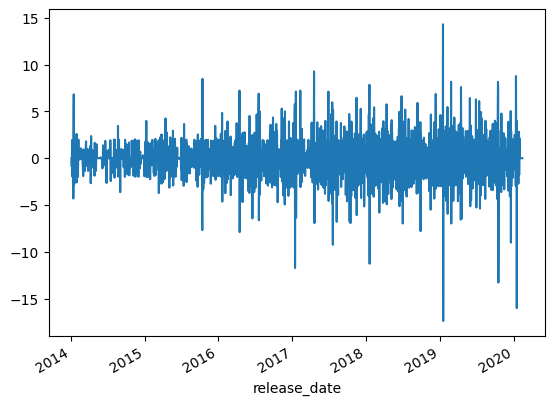

In [418]:
sentiment_df["BAC_diff"].plot()

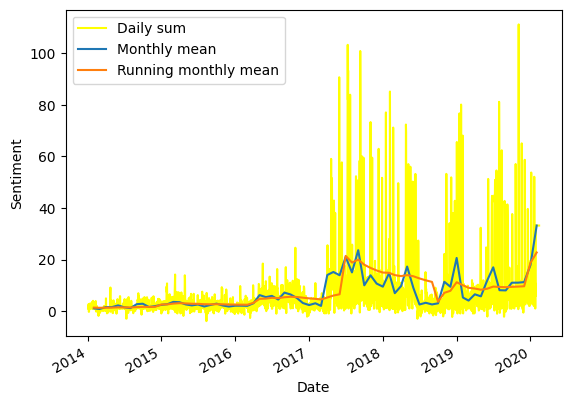

In [415]:
sentiment_df["AAPL_daily"].plot(color = "yellow", label = "Daily sum")
sentiment_monthly_df["AAPL_mean"].plot(label = "Monthly mean")
sentiment_monthly_df["AAPL_run_mean"].plot(label = "Running monthly mean")
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.legend()
plt.show()

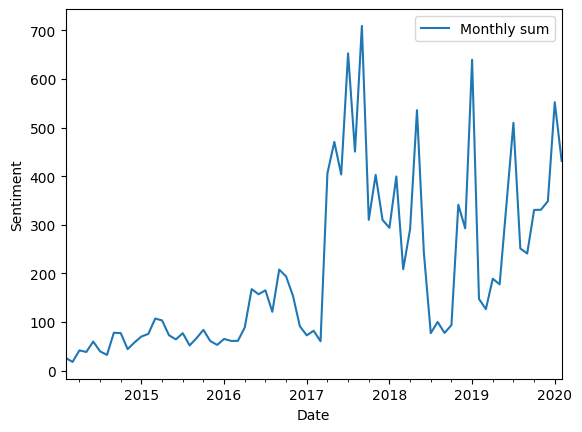

In [416]:
sentiment_monthly_df["AAPL_sum"].plot(label = "Monthly sum")
plt.ylabel("Sentiment")
plt.xlabel("Date")
plt.legend()
plt.show()

In [417]:
sentiment_df.to_csv("../data/sentiment_daily_data.csv")

In [425]:
def plot_daily(df, type):
    fig = plt.figure(figsize= (18, 20))
    j = 0
    for column in df.columns:
        if f"_{type}" in column:
            j+=1
            plt.subplot(5, 4, j)
            df[column].plot(label = column)
            plt.ylabel("sentiment")
            plt.xlabel("date")
            plt.legend()

    plt.suptitle("Daily sum")
    fig.tight_layout(pad = 3)
    plt.show()

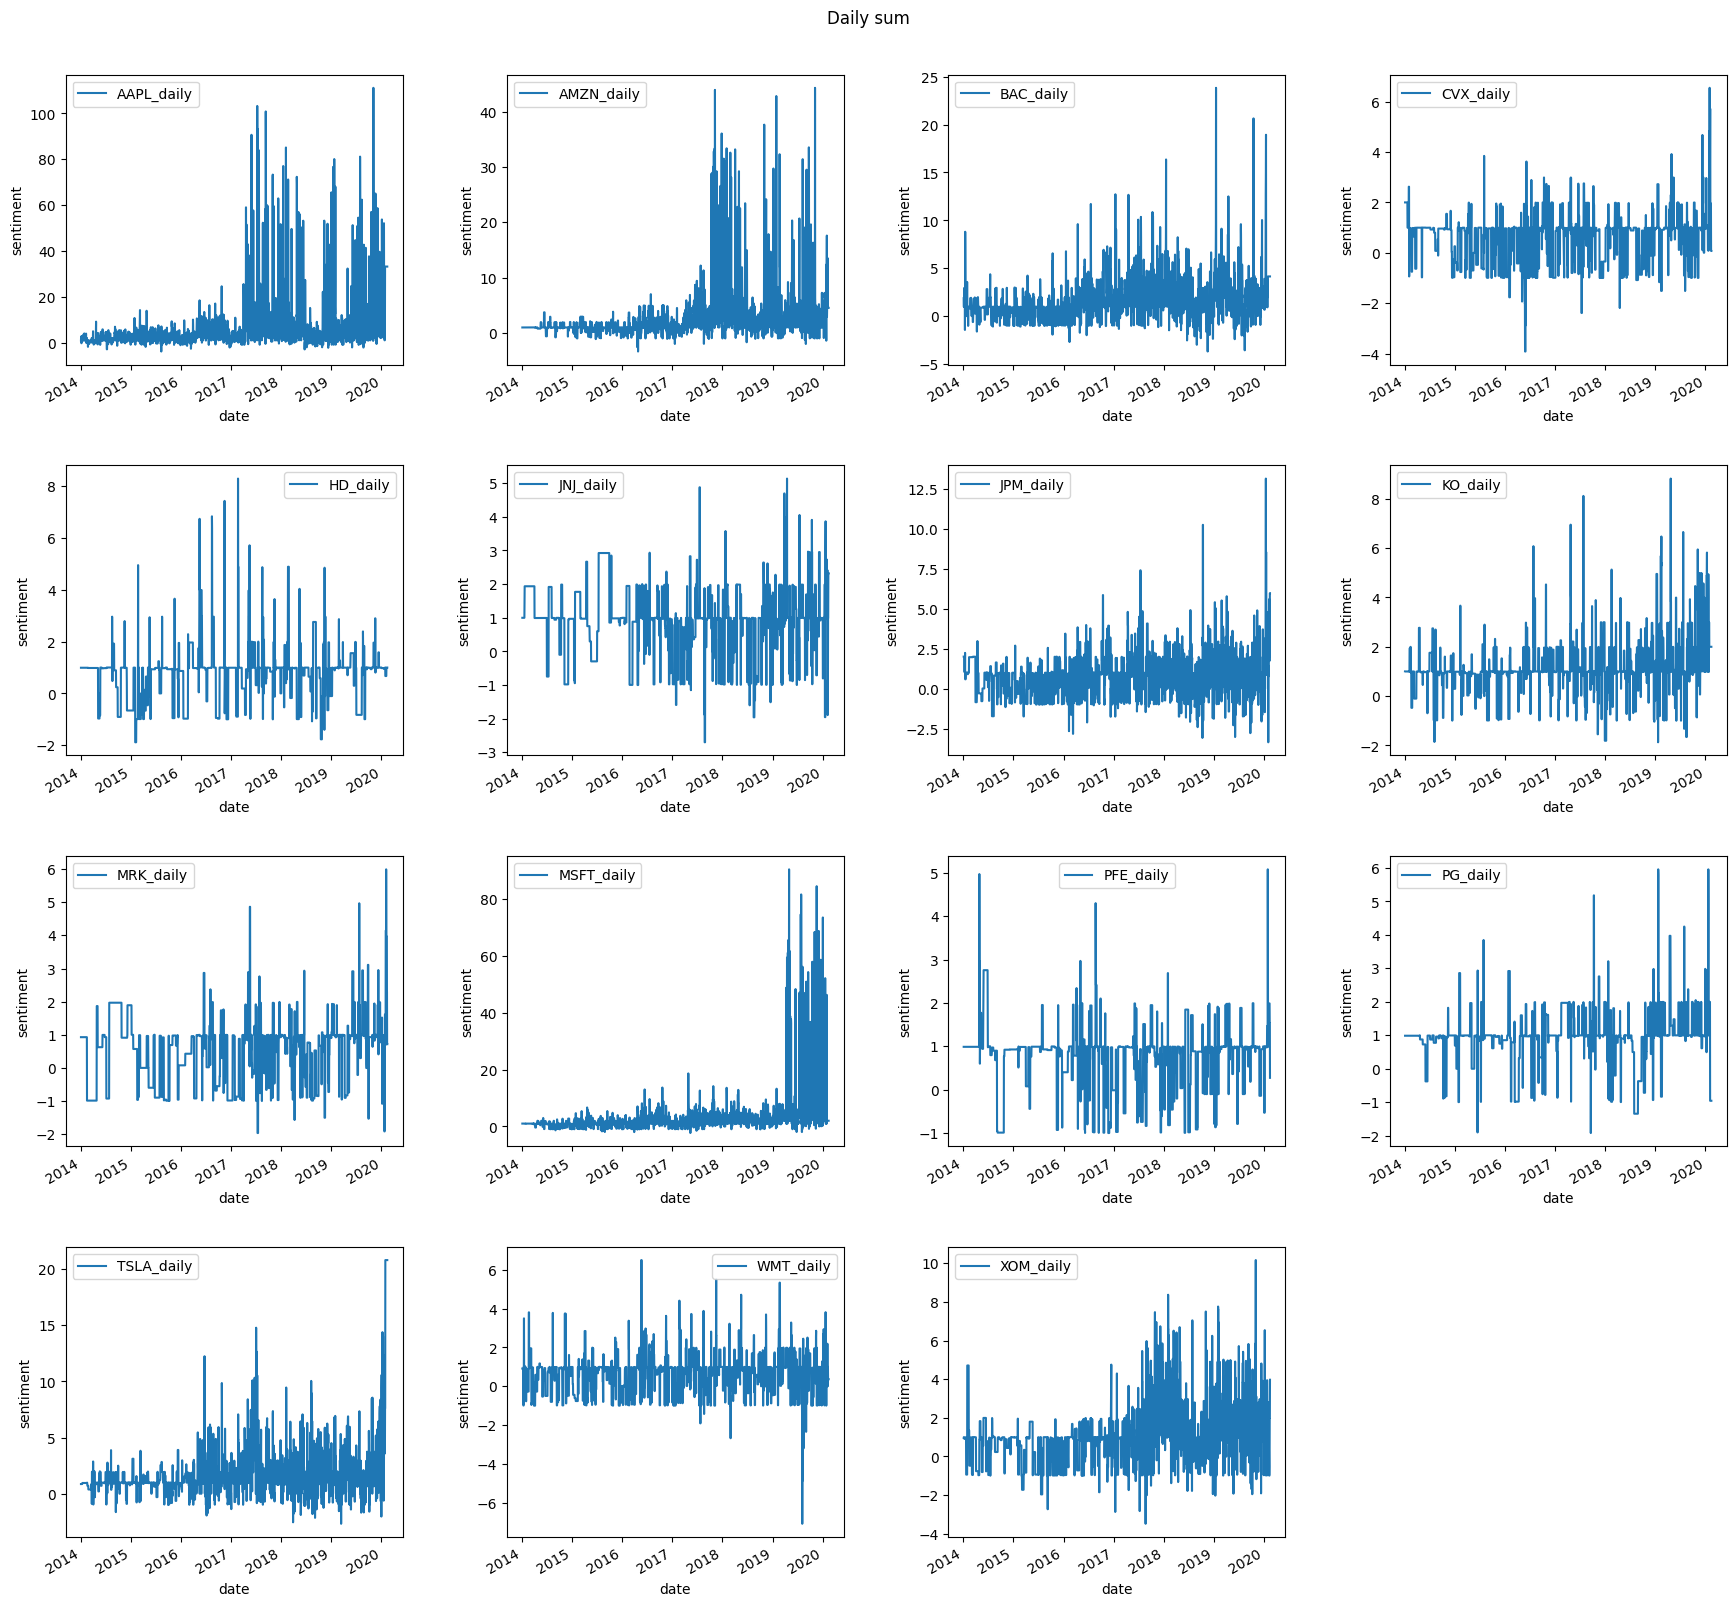

In [423]:
plot_daily(sentiment_df, "daily")

Some stocks have significanty larger sums for later dates (especially AAPL, TSLA and MSFT). A pittfall for us can be that this is not because there is more sentiment, but because there are simply more articles being collected for the dataset.

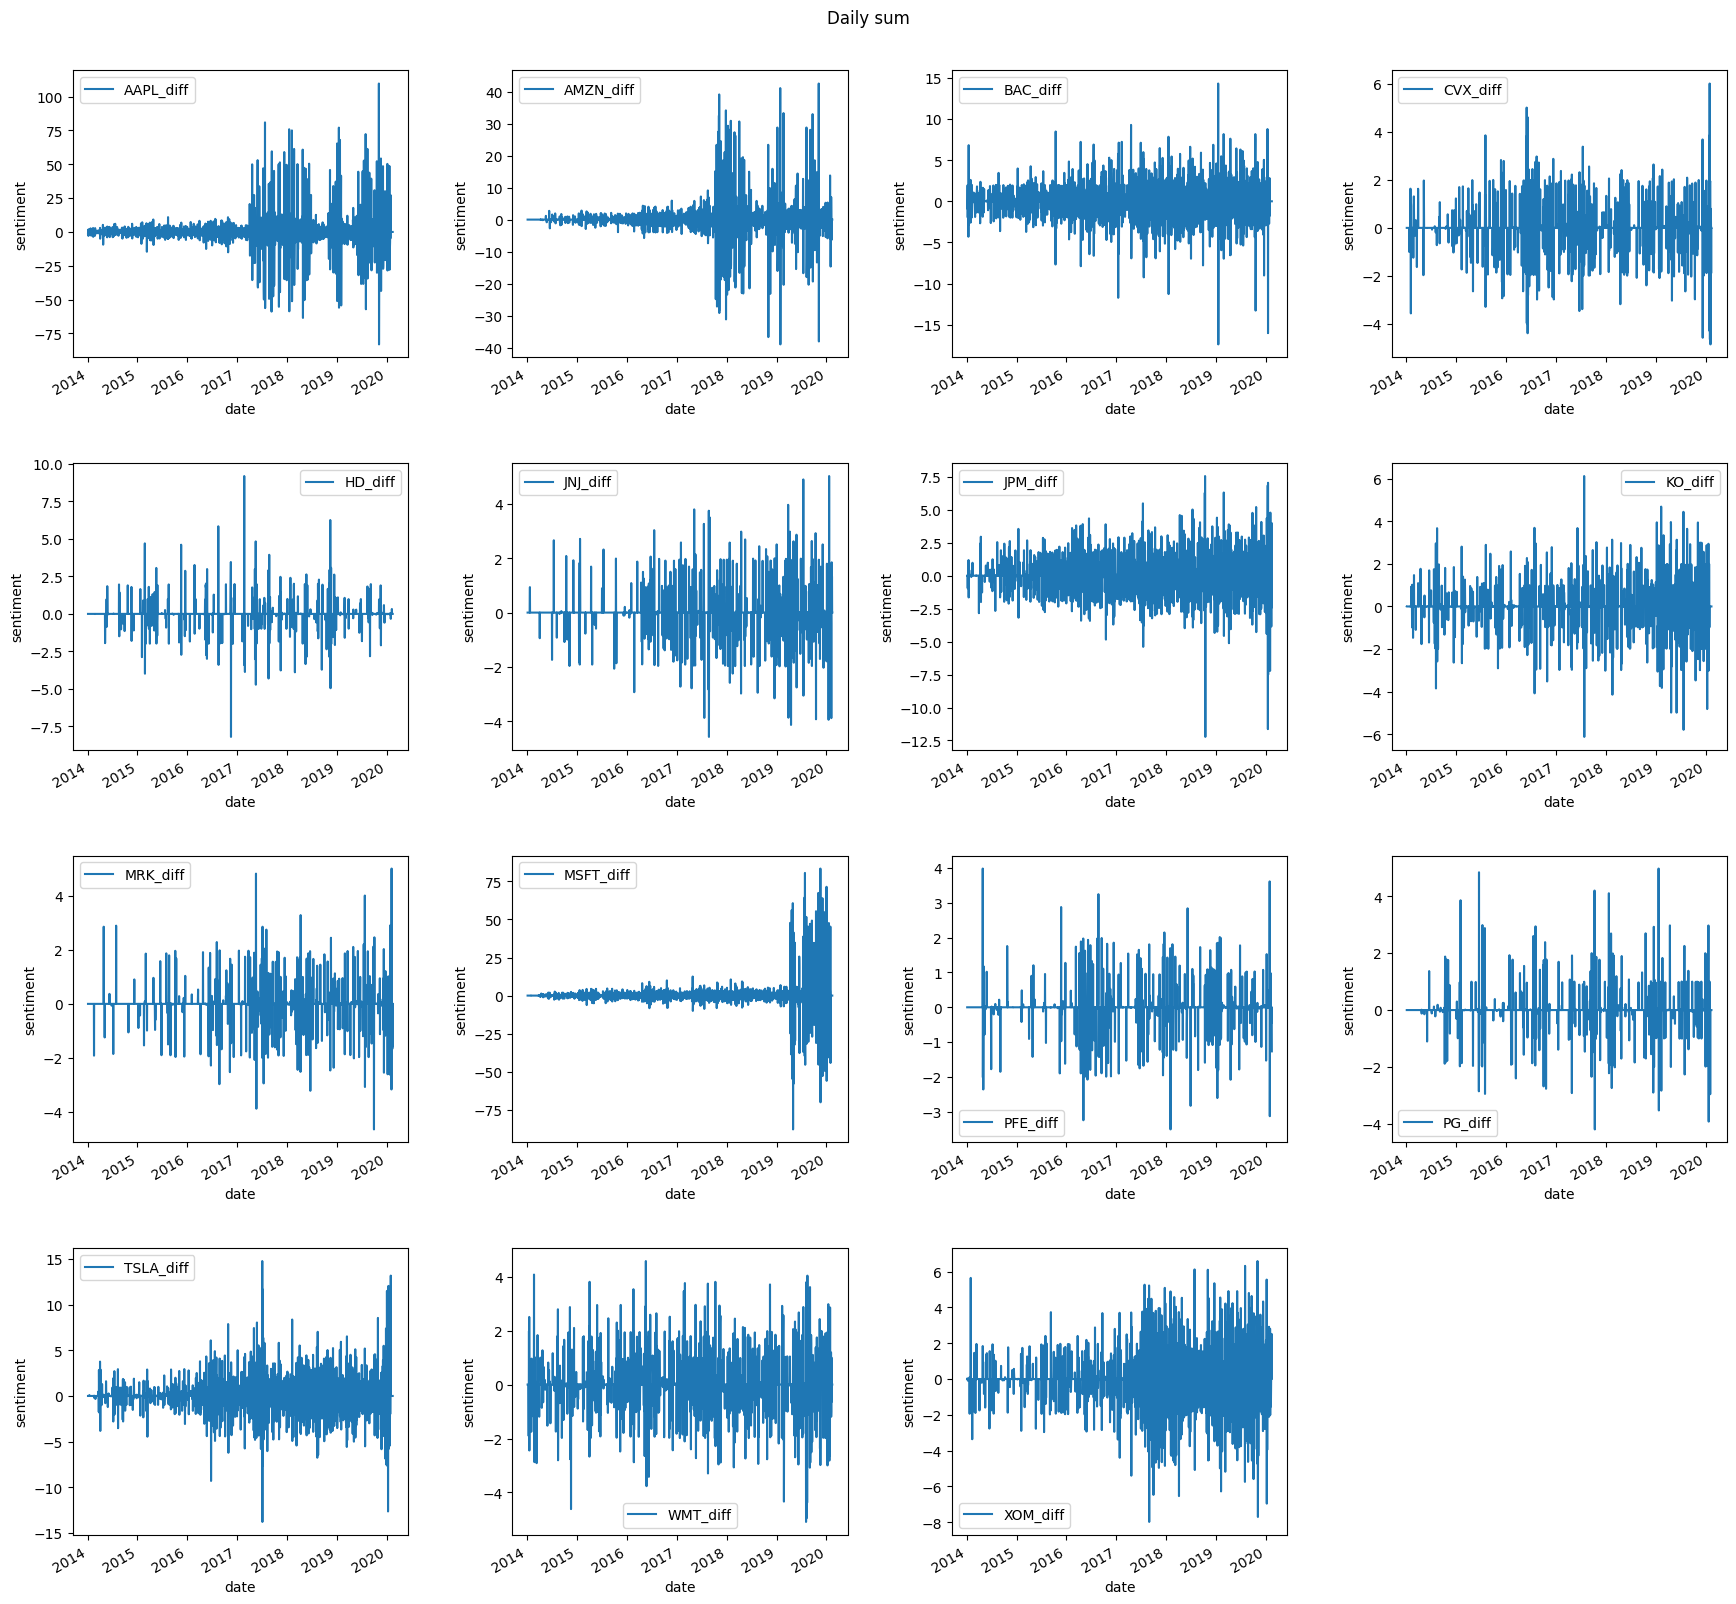

In [426]:
plot_daily(sentiment_df, "diff")